In [60]:
%matplotlib inline
#inline

In [44]:
import itertools
import math
import pickle
import subprocess
from io import StringIO
from os import path
from tempfile import TemporaryDirectory

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import pandas as pd
from scipy.stats import chi2, entropy

In [4]:
def data_path(set_number):
    return 'data/sample-laser-radar-measurement-data-{}.txt'.format(set_number)

In [56]:
#
# Run the UnscentedKF program with the given arguments and return the output.
#
def run(set_number, use_laser=None, use_radar=None,
        std_a=None, std_yawdd=None, lambd=None):
    with TemporaryDirectory() as tmp:
        output_path = path.join(tmp, 'output.txt')
        command = [
          'build/UnscentedKF',
          data_path(set_number),
          output_path,
          'true', # tweak output for reading by this tool
        ]
        if use_laser is not None:
            command += [
              str(use_laser).lower(),
              str(use_radar).lower(),
              str(std_a),
              str(std_yawdd),
              str(lambd)
            ]
        result = subprocess.run(
          command,
          stdout=subprocess.PIPE,
          stderr=subprocess.PIPE,
          universal_newlines=True
        )
        with open(output_path, 'r') as output_file:
            return result, output_file.read()

In [57]:
#
# Since we've already computed the RMSEs, just extract them from stdout.
#
def extract_rmse(result):
    if result.returncode != 0:
        return None
    lines = result.stdout.splitlines()
    rmse_start = lines.index('Accuracy - RMSE:') + 1
    rmse_end = rmse_start + 4
    return [float(rmse) for rmse in lines[rmse_start:rmse_end]]

SENSOR_INDEX = 11
NIS_INDEX = 12

def check_output_header_line(line):
    fields = line.split()
    assert len(fields) == 13
    assert fields[SENSOR_INDEX] == 'sensor'
    assert fields[NIS_INDEX] == 'NIS'

def extract_nis(output):
    output = output.splitlines()
    check_output_header_line(output[0])
    rows = [
        output[i].split()
        for i in range(1, len(output))
    ]
    return [
        [float(row[NIS_INDEX]) for row in rows if row[SENSOR_INDEX] == sensor]
        for sensor in ['L', 'R'] 
    ]

In [7]:
#
# This is the NIS score test suggested in the lecture: find the expected NIS
# based on the 95th percentile of the Chi^2 distribution with the relevant
# number of degrees of freedom (e.g. NIS ~ 7.8 for 3 DoF). Then find the
# percentage of observed NIS scores that are below that threshold. If the answer
# is close to 95%, that suggests that the filter is consistent.
#
def find_nis_quantile(nis_scores, df, quantile=0.95):
    if len(nis_scores) == 0: return float('nan')
    threshold = chi2.ppf(quantile, df)
    return sum(nis < threshold for nis in nis_scores) / len(nis_scores)

# Check: this number should be about 0.95
find_nis_quantile(chi2.rvs(2, size=1000), 2)

0.95099999999999996

In [8]:
#
# Compute the Kullback–Leibler divergence between the empirical distribution
# of NIS scores and the Chi^2 distribution with the given number of degrees of
# freedom. If the empirical distribution of the NIS scores is close to the
# expected Chi^2 distribution, so the filter is consistent, then the returned
# KL-div will be small.
#
def find_nis_kl_div(nis_scores, df, num_bins=21):
    if len(nis_scores) == 0: return float('nan')
    if not np.all(np.isfinite(nis_scores)): return float('nan')
    # Pick the bins so that we expect an equal mass in each bin, according to
    # the Chi^2 distribution with the appropriate number of degrees of freedom.
    xs = np.linspace(0, 1, num_bins)
    pk, _ = np.histogram(nis_scores, bins=chi2.ppf(xs, df))
    pk = pk.astype(np.double) / np.sum(pk)
    qk = np.diff(xs)
    return entropy(pk, qk)

# Check: this number should be near zero.
find_nis_kl_div(chi2.rvs(2, size=1000), 2)

0.0060205764774314691

In [9]:
# From http://stackoverflow.com/a/40623158/2053820
def dict_product(dicts):
    """
    >>> list(dict_product(dict(number=[1,2], character='ab')))
    [{'character': 'a', 'number': 1},
     {'character': 'a', 'number': 2},
     {'character': 'b', 'number': 1},
     {'character': 'b', 'number': 2}]
    """
    return (dict(zip(dicts, x)) for x in itertools.product(*dicts.values()))

In [10]:
def evaluate(params):
    result, output = run(**params)
    if result.returncode == 0:
        rmse = extract_rmse(result)
        laser_nis_scores, radar_nis_scores = extract_nis(output)
    else:
        rmse = [float('inf')] * 4
        laser_nis_scores = []
        radar_nis_scores = []

    laser_df = 2
    radar_df = 3
    return {
        'px_rmse': rmse[0],
        'py_rmse': rmse[1],
        'vx_rmse': rmse[2],
        'vy_rmse': rmse[3],
        'laser_nis_kl_div': find_nis_kl_div(laser_nis_scores, laser_df),
        'laser_nis_quantile': find_nis_quantile(laser_nis_scores, laser_df),
        'radar_nis_kl_div': find_nis_kl_div(radar_nis_scores, radar_df),
        'radar_nis_quantile': find_nis_quantile(radar_nis_scores, radar_df)
    }

In [12]:
# First grid:
#         'std_a': np.linspace(0.1, 10, 20).tolist(),
#         'std_yawdd': (math.pi / np.linspace(0.1, 10, 20)).tolist(),
#         'lambd': np.linspace(-10, 10, 40).tolist()
# Yielded only 30 out of 32000 points that met spec.
# Narrowed the ranges for the second grid.
# Then added a few more std_a and std_yawdd points, because the
# best ones were near the edge of the space.
#         'std_a': np.concatenate([
#             np.linspace(0.2, 0.5, 10),
#             np.linspace(0.3, 0.5, 10),
#             np.linspace(0.5, 2.0, 20)]).tolist(),
#         'std_yawdd': (math.pi / np.concatenate([
#                 np.linspace(6.0, 8.0, 10),
#                 np.linspace(4.0, 6.0, 20)])).tolist(),
#         'lambd': np.linspace(-6, -1, 20).tolist()
RESULTS_FILE = 'data/search.pickle'

In [ ]:
def search():
    if path.isfile(RESULTS_FILE):
        with open(RESULTS_FILE, 'rb') as f:
            results = pickle.load(f)
    else:
        results = {}

    keys = {
        'set_number': [1, 2],
        'use_laser': [True],
        'use_radar': [True],
        'std_a': np.linspace(0.2, 2.0, 20).tolist(),
        'std_yawdd': (math.pi / np.linspace(4.0, 8.0, 20)).tolist(),
        'lambd': np.linspace(-6, -1, 20).tolist()
    }

    for key in dict_product(keys):
        frozen_key = frozenset(key.items())
        if frozen_key in results:
            continue

        results[frozen_key] = evaluate(key)

        with open(RESULTS_FILE, 'wb') as f:
            pickle.dump(results, f, pickle.HIGHEST_PROTOCOL)

search()

In [13]:
def load_results():
    with open(RESULTS_FILE, 'rb') as f:
        return pickle.load(f)

# Pair up the dataset 1 and dataset 2 results --- we want to
# consider both for each set of parameters.
def group_results(results):
    grouped_results = {}
    for key, value in results.items():
        key_dict = dict(key)
        set_number = key_dict.pop('set_number')
        key_without_set_number = frozenset(key_dict.items())
        if key_without_set_number in grouped_results:
            grouped_results[key_without_set_number][set_number] = value
        else:
            grouped_results[key_without_set_number] = {set_number: value}
    return grouped_results

GROUPED_RESULTS = group_results(load_results())
len(GROUPED_RESULTS)

8000

### Apply max RMSE constraint

In [18]:
def make_single_position_rmse_vector(values):
    return np.array([
        values['px_rmse'],
        values['py_rmse'],
    ])

def make_single_speed_rmse_vector(values):
    return np.array([
        values['vx_rmse'],
        values['vy_rmse'],
    ])

def make_single_rmse_vector(values):
    return np.concatenate([
        make_single_position_rmse_vector(values),
        make_single_speed_rmse_vector(values),
    ])

def make_rmse_vector(values):
    return np.concatenate([
        make_single_rmse_vector(values[1]),
        make_single_rmse_vector(values[2])
    ])

MAX_RMSES = {
    1: {
        'px_rmse': 0.09,
        'py_rmse': 0.09,
        'vx_rmse': 0.65,
        'vy_rmse': 0.65
    },
    2: {
        'px_rmse': 0.20,
        'py_rmse': 0.20,
        'vx_rmse': 0.55,
        'vy_rmse': 0.55
    }
}
MAX_RMSE_VECTOR = make_rmse_vector(MAX_RMSES)

def is_result_in_spec(value):
    rmse_vector = make_rmse_vector(value)
    if np.any(np.isnan(rmse_vector)):
        return False
    return np.all(rmse_vector <= MAX_RMSE_VECTOR)

# We need it to be in spec for both dataset 1 and dataset 2.  
def find_results_in_spec(results):
    return {
        key: value
        for key, value in results.items()
        if is_result_in_spec(value)
    }

def make_single_nis_vector(values, consistency_score):
    return np.array([
        values['laser_nis_' + consistency_score],
        values['radar_nis_' + consistency_score]
    ])

def make_nis_vector(values, consistency_score):
    return np.concatenate([
        make_single_nis_vector(values[1], consistency_score),
        make_single_nis_vector(values[2], consistency_score)
    ])

def make_result_vector(values, consistency_score):
    return np.concatenate([
        make_single_rmse_vector(values[1]),
        make_single_nis_vector(values[1], consistency_score),
        make_single_rmse_vector(values[2]),
        make_single_nis_vector(values[2], consistency_score)
    ])

RESULTS_IN_SPEC = find_results_in_spec(GROUPED_RESULTS)
len(RESULTS_IN_SPEC)

1083

In [15]:
# v1 dominates v2 if all entries of v1 are smaller
def dominates(v1, v2):
    return np.all(v1 < v2)

def find_non_dominated(results, consistency_score):
    keys = list(results.keys())
    vectors = [
        make_result_vector(results[keys[i]], consistency_score)
        for i in range(len(keys))
    ]
    return {
        keys[i]: results[keys[i]]
        for i in range(len(keys))
        if not any(
            dominates(vectors[j], vectors[i])
            for j in range(len(keys)))
    }

NON_DOMINATED_KL_DIV_RESULTS = \
    find_non_dominated(RESULTS_IN_SPEC, 'kl_div')
len(NON_DOMINATED_KL_DIV_RESULTS)

1083

In [ ]:
dom = list(set(RESULTS_IN_SPEC) - set(NON_DOMINATED_KL_DIV_RESULTS))[0]
domv = make_result_vector(RESULTS_IN_SPEC[dom], 'kl_div')
(dom, domv)

In [ ]:
[
    (key, make_result_vector(value, 'kl_div'))
    for key, value in RESULTS_IN_SPEC.items()
    if dominates(make_result_vector(value, 'kl_div'), domv)
]

In [17]:
def average_rmse(rmses):
    return np.sqrt(np.dot(rmses, rmses) / len(rmses))
    
def plot_in_parameter_space(results, size_scale=30):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    data = np.array([
        [
            dict(key)['std_a'],
            dict(key)['std_yawdd'],
            dict(key)['lambd'],
            size_scale * np.mean(make_nis_vector(value, 'kl_div')),
            average_rmse(make_rmse_vector(value))
        ]
        for key, value in results.items()
    ])
    p = ax.scatter(data[:,0], data[:,1], data[:,2],
                   s=data[:,3], c=data[:,4], cmap='cool')
    ax.set_xlabel('std_a')
    ax.set_ylabel('std_yawdd')
    ax.set_zlabel('lambda')
    ax.view_init(elev=45, azim=-45)
    fig.colorbar(p)
    
plot_in_parameter_space(NON_DOMINATED_KL_DIV_RESULTS)

In [40]:
def make_position_rmse_vector(values):
    return np.concatenate([
        make_single_position_rmse_vector(values[1]),
        make_single_position_rmse_vector(values[2])
    ])

def make_speed_rmse_vector(values):
    return np.concatenate([
        make_single_speed_rmse_vector(values[1]),
        make_single_speed_rmse_vector(values[2])
    ])

def plot_in_3d_objective_space(results, consistency_score, pareto_only):
    keys = list(results.keys())
    values = [results[key] for key in keys]
    data = np.array([
        [
            np.mean(make_nis_vector(value, consistency_score)),
            average_rmse(make_position_rmse_vector(value)),
            average_rmse(make_speed_rmse_vector(value))
        ]
        for value in values
    ])
    
    frontier = None
    if pareto_only:
        indexes = [
            i
            for i in range(len(keys))
            if not any (
                np.all(data[j,:] < data[i,:])
                for j in range(len(keys))
            )
        ]
        frontier = pd.DataFrame([
            (
                key_i['std_a'], key_i['std_yawdd'], key_i['lambd'],
                data[i,0], data[i,1], data[i,2]
            )
            for i in indexes
            for key_i in [dict(keys[i])]
        ], columns=(
            'std_a', 'std_yawdd', 'lambda',
            'average NIS ' + consistency_score,
            'average position RMSE', 'average speed RMSE'
        )).sort_values('average NIS ' + consistency_score)
    else:
        indexes = range(len(keys))        
    
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    p = ax.scatter(data[indexes,0], data[indexes,1], data[indexes,2])
    ax.set_xlabel('average NIS')
    ax.set_ylabel('average position RMSE')
    ax.set_zlabel('average speed RMSE')
    ax.view_init(elev=10, azim=-70)

    for i in indexes:
        key = dict(keys[i])
        text = "{std_a:.3f},{std_yawdd:.3f},{lambd:.3f}".format(**key)
        ax.text(data[i,0], data[i,1], data[i,2], text, size=8)
    return frontier
    
plot_in_3d_objective_space(NON_DOMINATED_KL_DIV_RESULTS, 'kl_div', pareto_only=True)

,std_a,std_yawdd,lambda,average NIS kl_div,average position RMSE,average speed RMSE
7,0.673684,0.573945,-4.947368,0.362015,0.144177,0.524638
15,0.578947,0.573945,-4.947368,0.366853,0.143662,0.517574
18,0.673684,0.552688,-4.684211,0.368870,0.144462,0.516531
26,0.484211,0.596903,-4.947368,0.369071,0.142793,0.512599
3,0.578947,0.552688,-4.684211,0.376018,0.143999,0.510514
9,0.484211,0.648807,-4.947368,0.376099,0.142183,0.519427
27,0.389474,0.596903,-4.947368,0.377134,0.142310,0.504292
13,0.484211,0.532949,-4.421053,0.378787,0.143960,0.501029
10,0.389474,0.621774,-4.947368,0.381172,0.142015,0.506598
20,0.484211,0.552688,-4.684211,0.381631,0.143516,0.504268


In [37]:
def plot_in_objective_space(results, consistency_score, pareto_only):
    keys = list(results.keys())
    values = [results[key] for key in keys]
    data = np.array([
        [
            np.mean(make_nis_vector(value, consistency_score)),
            average_rmse(make_rmse_vector(value))
        ]
        for value in values
    ])
    
    frontier = None
    if pareto_only:
        indexes = [
            i
            for i in range(len(keys))
            if not any (
                np.all(data[j,:] < data[i,:])
                for j in range(len(keys))
            )
        ]
        frontier = pd.DataFrame([
            (
                key_i['std_a'], key_i['std_yawdd'], key_i['lambd'],
                data[i,0], data[i,1]
            )
            for i in indexes
            for key_i in [dict(keys[i])]
        ], columns=(
            'std_a', 'std_yawdd', 'lambda',
            'average NIS ' + consistency_score, 'average RMSE'
        )).sort_values('average NIS ' + consistency_score)
    else:
        indexes = range(len(keys))        
    
    fig, ax = plt.subplots()
    ax.scatter(data[indexes,0], data[indexes,1])
    
    for i in indexes:
        key = dict(keys[i])
        text = "{std_a:.3f},{std_yawdd:.3f},{lambd:.3f}".format(**key)
        ax.annotate(text, (data[i,0], data[i,1]))
    
    plt.xlabel('average NIS ' + consistency_score)
    plt.ylabel('average RMSE')
    
    return frontier
plot_in_objective_space(NON_DOMINATED_KL_DIV_RESULTS, 'kl_div', pareto_only=True)

,std_a,std_yawdd,lambda,average NIS kl_div,average RMSE
3,0.673684,0.573945,-4.947368,0.362015,0.384728
7,0.578947,0.573945,-4.947368,0.366853,0.379817
10,0.673684,0.552688,-4.684211,0.368870,0.379258
12,0.484211,0.596903,-4.947368,0.369071,0.376263
1,0.578947,0.552688,-4.684211,0.376018,0.375073
13,0.389474,0.596903,-4.947368,0.377134,0.370515
6,0.484211,0.532949,-4.421053,0.378787,0.368615
11,0.484211,0.514571,-4.157895,0.382494,0.367557
8,0.294737,0.621774,-4.947368,0.390935,0.365830
0,0.389474,0.514571,-3.894737,0.397966,0.364123


In [90]:
def find_weighted_score(value, rmse_weight,
                        consistency_weight, consistency_score):
    consistency = np.mean(make_nis_vector(value, consistency_score))
    # Want to be as close to 0.95 as possible.
    if consistency_score == 'quantile':
        consistency = np.abs(consistency - 0.95)
    return \
        rmse_weight * average_rmse(make_rmse_vector(value)) + \
        consistency_weight * consistency
    
def find_top_results(
    results, n,
    rmse_weight=1,
    consistency_weight=0.5,
    consistency_score='kl_div'):
    sorted_results = sorted(
        results.items(),
        key=lambda pair: find_weighted_score(
            pair[1], rmse_weight, consistency_weight, consistency_score))
    return [
        (value, dict(key))
        for key, value in sorted_results
    ][0:n]
find_top_results(NON_DOMINATED_KL_DIV_RESULTS, 5)

[({1: {'laser_nis_kl_div': 0.37553548179293511,
    'laser_nis_quantile': 1.0,
    'px_rmse': 0.0779885,
    'py_rmse': 0.0889974,
    'radar_nis_kl_div': 0.23713251089675411,
    'radar_nis_quantile': 0.8202614379084967,
    'vx_rmse': 0.600553,
    'vy_rmse': 0.589636},
   2: {'laser_nis_kl_div': 0.29935889589024861,
    'laser_nis_quantile': 1.0,
    'px_rmse': 0.182991,
    'py_rmse': 0.188175,
    'radar_nis_kl_div': 0.60311914634727959,
    'radar_nis_quantile': 0.98999999999999999,
    'vx_rmse': 0.31891,
    'vy_rmse': 0.440546}},
  {'lambd': -4.421052631578947,
   'std_a': 0.4842105263157895,
   'std_yawdd': 0.5329487537339828,
   'use_laser': True,
   'use_radar': True}),
 ({1: {'laser_nis_kl_div': 0.35120476772493181,
    'laser_nis_quantile': 1.0,
    'px_rmse': 0.0802604,
    'py_rmse': 0.0897757,
    'radar_nis_kl_div': 0.23230780376276713,
    'radar_nis_quantile': 0.82189542483660127,
    'vx_rmse': 0.604555,
    'vy_rmse': 0.590912},
   2: {'laser_nis_kl_div': 0.323439

In [ ]:
# could do a grid, or we could use an optimiser...
# but I guess it's multiobjective
# and it's pretty quick.
# probably simpler to just grid it out

# record for each param setting:
#   for each dataset:
#     RMSEs
#     NIS quantile
#     NIS KLDIV
#     or a failure code
# then I guess we want another script to thin it out with:
#  - not a numerical failure
#  - meets spec in terms of RMSEs on DS1 and DS2
#  - not dominated in terms of the 8 RMSEs and 2 KLdivs (pareto)
#
# can't plot 10 dimensions, but can project into mean RMSE and mean KLdiv space
# and we only have 3 real params, so we can do a 3d plot

# odd that we didn't get any dominated solutions... maybe a bug
# but maybe we should instead do pareto on the 2d plot. That looks like we could do
# some pareto analysis to get a small number of solutions.

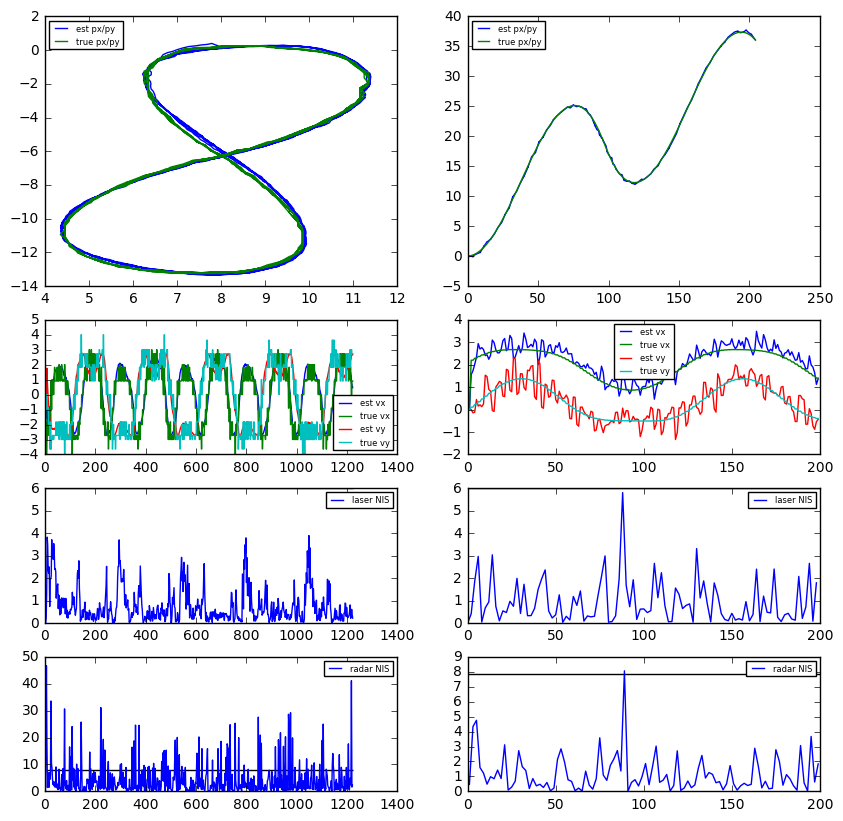

In [91]:
def run_and_read_output(**params):
    result, output = run(**params)
    if result.returncode == 0:
        rmse = extract_rmse(result)
        df = pd.read_table(StringIO(output))
    else:
        rmse = [float('inf')] * 4
        df = None
    return rmse, df

def plot_output():
    fig, axes = plt.subplots(
        4, 2,
        figsize=(10, 10),
        gridspec_kw={'height_ratios':[2, 1, 1, 1]}
    )
    for set_number in [1, 2]:
        rmse, df = run_and_read_output(set_number=set_number)
        
        df['vx'] = df['v'] * np.cos(df['yaw_angle'])
        df['vy'] = df['v'] * np.sin(df['yaw_angle'])
        
        ax = axes[0][set_number - 1]
        ax.plot(df['px'], df['py'], label='est px/py')
        ax.plot(df['px_true'], df['py_true'], label='true px/py')
        ax.legend(loc='best', prop={'size': 6})
        
        ax = axes[1][set_number - 1]
        ax.plot(df['vx'], label='est vx')
        ax.plot(df['vx_true'], label='true vx')
        ax.plot(df['vy'], label='est vy')
        ax.plot(df['vy_true'], label='true vy')
        ax.legend(loc='best', prop={'size': 6})
        
        ax = axes[2][set_number - 1]
        ax.plot(df[df.sensor == 'L']['NIS'], label='laser NIS')
        ax.hlines(chi2.ppf(0.95, 2), 0, len(df.index))
        ax.legend(loc='best', prop={'size': 6})

        ax = axes[3][set_number - 1]
        ax.plot(df[df.sensor == 'R']['NIS'], label='radar NIS')
        ax.hlines(chi2.ppf(0.95, 3), 0, len(df.index))
        ax.legend(loc='best', prop={'size': 6})
        
plot_output()

In [43]:
pd.read_table('data/output-1.txt')

,px,py,v,yaw_angle,yaw_rate,px_measured,py_measured,px_true,py_true,vx_true,vy_true,NIS
0,8.46292,0.243462,0.000000,0.000000e+00,0.000000e+00,8.46292,0.243462,8.60,2.500000e-01,-3.000290,0.000000,0.000000
1,8.45008,0.249461,-0.105288,4.336810e-18,1.214310e-17,8.44818,0.251553,8.45,2.500000e-01,-3.000270,0.000000,0.001994
2,8.46989,0.247726,-0.034470,3.642100e-04,8.139610e-06,8.56759,0.241943,8.45,2.500000e-01,0.000000,0.000000,0.126329
3,8.46333,0.250094,-0.037477,-1.940530e-04,-5.485160e-06,8.45582,0.253997,8.45,2.500000e-01,0.000000,0.000000,0.005356
4,8.36450,0.250634,-0.945889,-9.830810e-03,-1.251840e-04,8.42544,0.254042,8.35,2.500000e-01,-1.819790,0.000000,18.736700
5,8.30108,0.250503,-0.965231,-7.870150e-03,-1.175030e-06,8.23962,0.249160,8.25,2.500000e-01,-1.819780,0.000000,0.239084
6,8.09034,0.221429,-1.746220,3.293430e-01,2.741480e-02,7.93286,0.188391,8.05,2.000000e-01,-3.999760,-0.999940,54.749900
7,7.98547,0.190940,-1.785910,3.444370e-01,2.751750e-02,7.84073,0.159858,7.85,1.500000e-01,-3.999720,-0.999930,1.275890
8,7.77864,0.440378,-2.078100,-1.227910e+00,-1.670670e-01,7.61269,0.155818,7.70,1.500000e-01,-2.999820,0.000000,16.658100
9,7.67863,0.392091,-2.167750,-7.721880e-01,-1.251980e-01,7.54016,0.159641,7.55,1.500000e-01,-2.999820,0.000000,5.086380
